# Step-1: Frame the problem and look at the big picture

## Our task is to build a model of housing prices in the state. This data includes metrics such as occupation, sleep duration, BMI Category  stress level. Our model should learn from this data and be able to predict the average quality of sleep required for the persons based on their designation and stress levels, given all the other metrics.

# Step-2: Get the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [3]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
df.shape

(374, 13)

In [5]:
df.fillna("None", inplace=True)

In [6]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


### Now we will strip Blood Pressure for better representation of the data

In [7]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

In [8]:
df.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps',
       'Sleep Disorder'],
      dtype='object')

In [9]:
df[['BP(Systolic)', 'BP(Diastolic)']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to numeric
df['BP(Systolic)'] = pd.to_numeric(df['BP(Systolic)'])
df['BP(Diastolic)'] = pd.to_numeric(df['BP(Diastolic)'])

# Drop the original 'Blood Pressure' column
df.drop(columns=['Blood Pressure'], inplace=True)

columns_list = ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'BP(Systolic)', 'BP(Diastolic)', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

# Reindex the columns in the dataframe
df = df.reindex(columns=columns_list)

In [10]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,BP(Systolic),BP(Diastolic),Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   BP(Systolic)             374 non-null    int64  
 10  BP(Diastolic)            374 non-null    int64  
 11  Heart Rate               374 non-null    int64  
 12  Daily Steps              374 non-null    int64  
 13  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(9), o

In [12]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BP(Systolic),BP(Diastolic),Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,128.553476,84.649733,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,7.748118,6.161611,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,115.000000,75.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,125.000000,80.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,130.000000,85.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,135.000000,90.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,142.000000,95.000000,86.000000,10000.000000


# 3. Explore the data to gain insights.

## Correlation Analysis

In [13]:
df.corr(numeric_only=True)

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BP(Systolic),BP(Diastolic),Heart Rate,Daily Steps
Person ID,1.000000,0.990516,0.296305,0.431612,0.149882,-0.394287,0.611551,0.590670,-0.225467,0.043844
Age,0.990516,1.000000,0.344709,0.473734,0.178993,-0.422344,0.605878,0.593839,-0.225606,0.057973
Sleep Duration,0.296305,0.344709,1.000000,0.883213,0.212360,-0.811023,-0.180406,-0.166570,-0.516455,-0.039533
Quality of Sleep,0.431612,0.473734,0.883213,1.000000,0.192896,-0.898752,-0.121632,-0.110151,-0.659865,0.016791
Physical Activity Level,0.149882,0.178993,0.212360,0.192896,1.000000,-0.034134,0.265416,0.382651,0.136971,0.772723
Stress Level,-0.394287,-0.422344,-0.811023,-0.898752,-0.034134,1.000000,0.102818,0.091811,0.670026,0.186829
BP(Systolic),0.611551,0.605878,-0.180406,-0.121632,0.265416,0.102818,1.000000,0.972885,0.294143,0.103342
BP(Diastolic),0.590670,0.593839,-0.166570,-0.110151,0.382651,0.091811,0.972885,1.000000,0.271092,0.241986
Heart Rate,-0.225467,-0.225606,-0.516455,-0.659865,0.136971,0.670026,0.294143,0.271092,1.000000,-0.030309
Daily Steps,0.043844,0.057973,-0.039533,0.016791,0.772723,0.186829,0.103342,0.241986,-0.030309,1.000000


<Axes: >

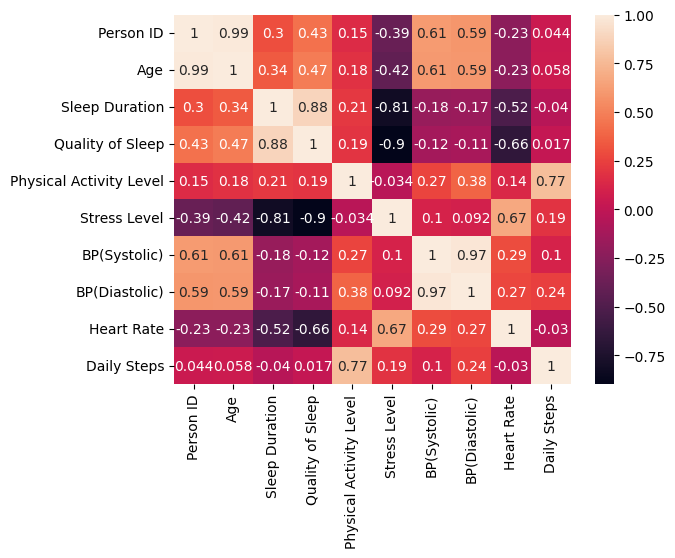

In [14]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

## Deep-down analysis(column-wise)

In [15]:
df.Gender.value_counts()

Gender
Male      189
Female    185
Name: count, dtype: int64

<Axes: xlabel='Age', ylabel='Count'>

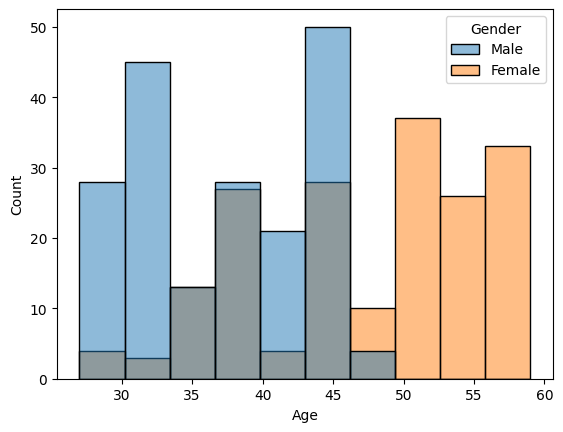

In [16]:
sns.histplot(data=df, x='Age', hue='Gender', color='lightblue')

In [17]:
df.Occupation.value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

<Axes: xlabel='Occupation', ylabel='count'>

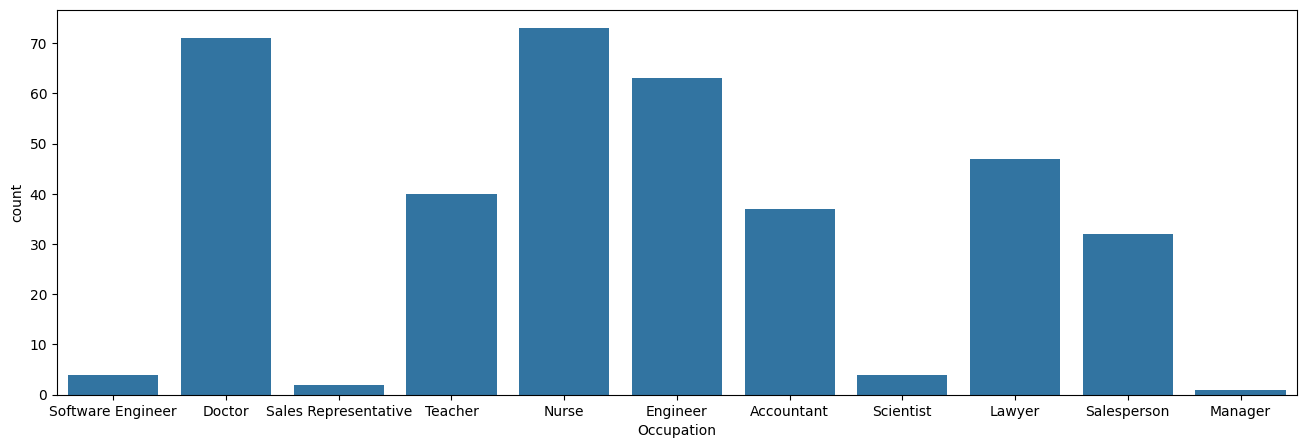

In [18]:
plt.figure(figsize=(16, 5))
sns.countplot(x=df.Occupation)

<Axes: xlabel='Occupation', ylabel='count'>

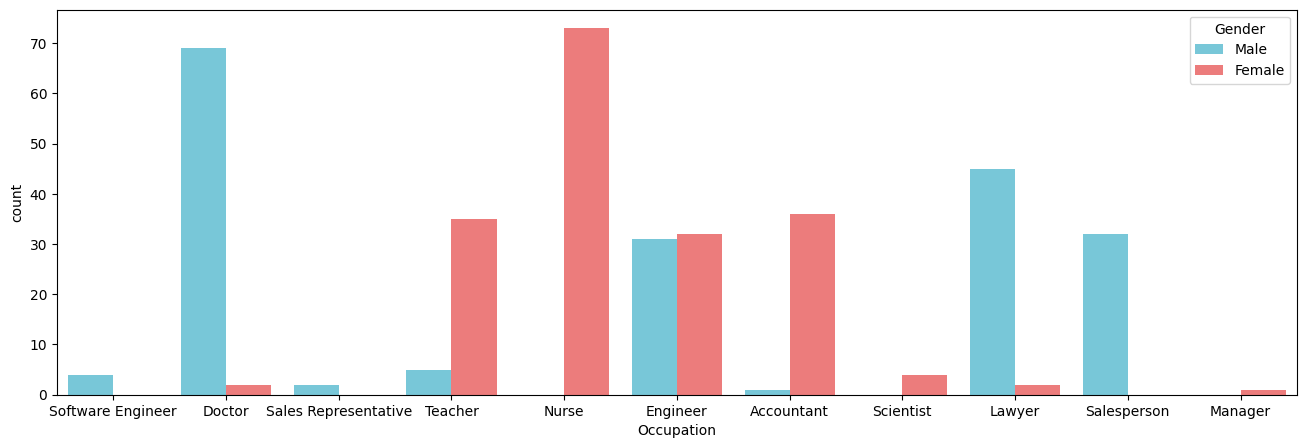

In [19]:
plt.figure(figsize=(16, 5))
sns.countplot(x='Occupation', hue='Gender', data=df ,palette={"#FF6969" , "#68D2E8"})

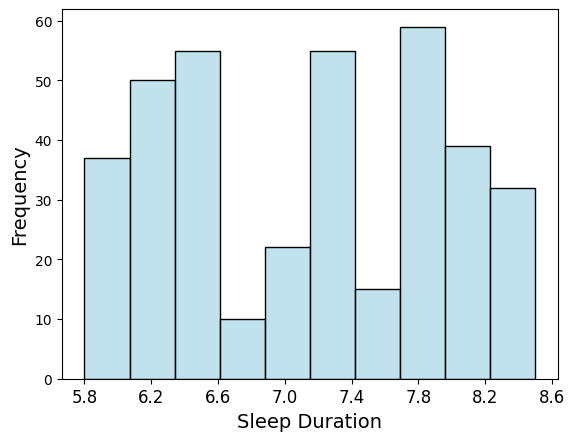

In [20]:
sns.histplot(df["Sleep Duration"] , color="lightblue" )

plt.xticks(ticks=np.arange(df["Sleep Duration"].min(), df["Sleep Duration"].max()+0.5, step=0.4), fontsize=12)
plt.xlabel("Sleep Duration", fontsize=14)
plt.ylabel("Frequency", fontsize=14)


plt.show()

In [21]:
pd.set_option('display.max_rows', None)
new = df.groupby("Sleep Duration")["Occupation"].value_counts().reset_index()
new

,Sleep Duration,Occupation,count
0,5.8,Scientist,2
1,5.9,Sales Representative,2
2,5.9,Nurse,1
3,5.9,Software Engineer,1
4,6.0,Doctor,18
5,6.0,Nurse,13
6,6.1,Nurse,15
7,6.1,Doctor,9
8,6.1,Software Engineer,1
9,6.2,Doctor,6


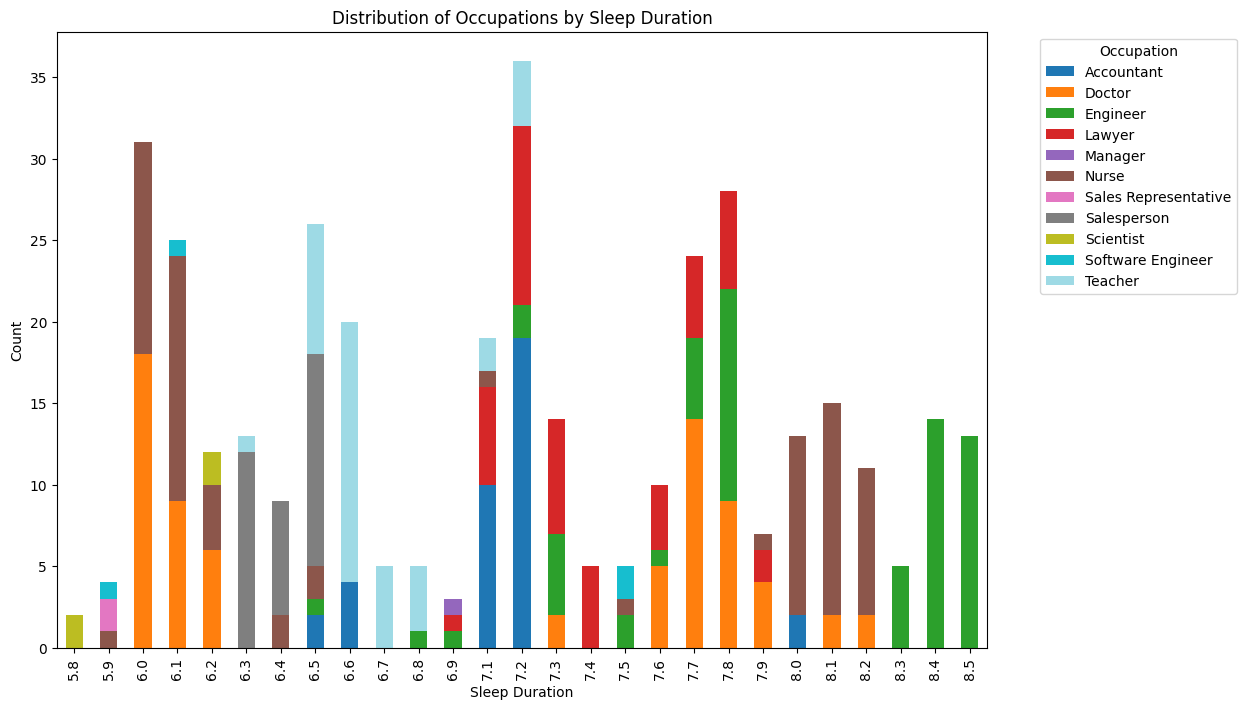

In [22]:
pivot_data = df.groupby(["Sleep Duration", "Occupation"]).size().unstack().fillna(0)

pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Distribution of Occupations by Sleep Duration')
plt.xlabel('Sleep Duration')
plt.ylabel('Count')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
df["Quality of Sleep"].value_counts()

Quality of Sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: count, dtype: int64

C:\Users\Surya Teja\AppData\Local\Temp\ipykernel_23428\622597476.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Quality of Sleep" ,data=df , palette="tab10")


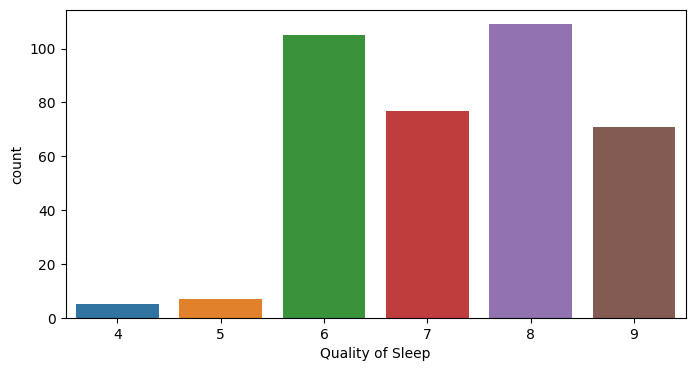

In [24]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Quality of Sleep" ,data=df , palette="tab10")
plt.show()

<Axes: xlabel='Quality of Sleep', ylabel='Occupation'>

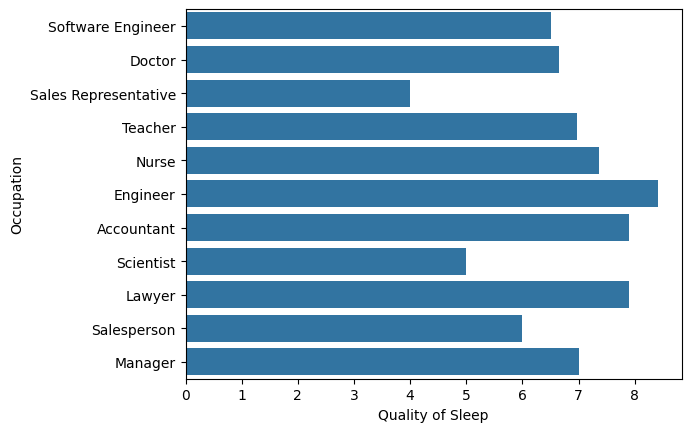

In [25]:
sns.barplot(data=df ,x="Quality of Sleep" , y="Occupation" , errorbar=None)

In [26]:
df["Physical Activity Level"].value_counts()

Physical Activity Level
60    70
30    68
45    68
75    67
90    67
40     6
55     6
35     4
50     4
70     3
42     2
32     2
80     2
65     2
85     2
47     1
Name: count, dtype: int64

<Axes: xlabel='Physical Activity Level', ylabel='count'>

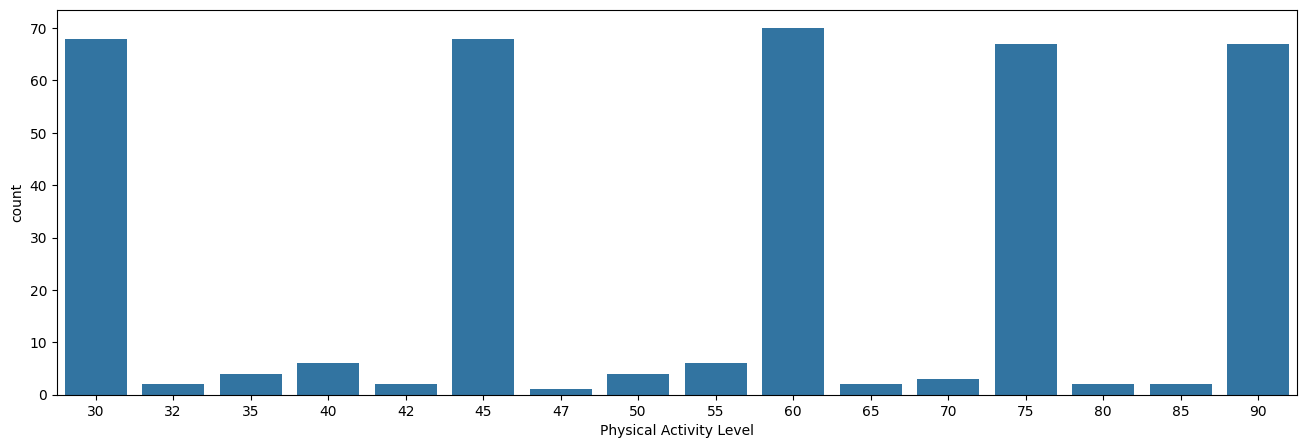

In [27]:
plt.figure(figsize=(16, 5))
sns.countplot(x=df["Physical Activity Level"])

In [28]:
df["Stress Level"].unique()

array([6, 8, 7, 4, 3, 5], dtype=int64)

C:\Users\Surya Teja\AppData\Local\Temp\ipykernel_23428\2486679485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Stress Level" ,data=df , palette="tab20")


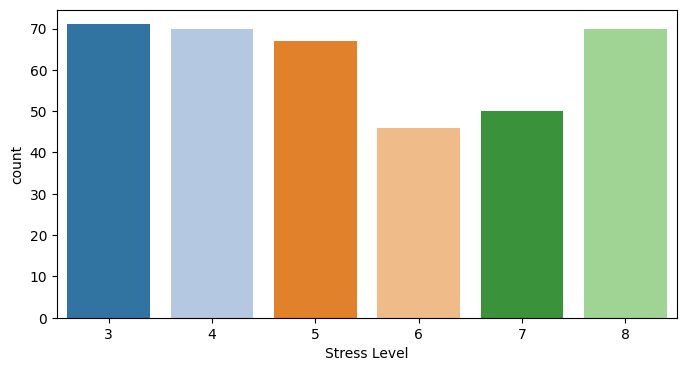

In [29]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Stress Level" ,data=df , palette="tab20")
plt.show()

In [30]:
df.groupby("Stress Level")["Occupation"].value_counts()

Stress Level  Occupation          
3             Engineer                34
              Nurse                   31
              Doctor                   4
              Accountant               2
4             Teacher                 31
              Accountant              26
              Engineer                 9
              Nurse                    4
5             Lawyer                  44
              Engineer                16
              Teacher                  2
              Software Engineer        2
              Doctor                   2
              Manager                  1
6             Doctor                  32
              Accountant               3
              Lawyer                   3
              Nurse                    2
              Scientist                2
              Teacher                  2
              Engineer                 1
              Software Engineer        1
7             Salesperson             32
              Accounta

In [31]:
df["BMI Category"].unique()

array(['Overweight', 'Normal', 'Obese', 'Normal Weight'], dtype=object)

In [32]:
df["BMI Category"].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [33]:
df["Heart Rate"].value_counts()

Heart Rate
68    94
70    76
72    69
65    67
75    36
78     5
85     3
80     3
84     2
83     2
73     2
67     2
74     2
77     2
81     2
76     2
69     2
86     2
82     1
Name: count, dtype: int64

In [34]:
df["Daily Steps"].value_counts()

Daily Steps
8000     101
6000      68
5000      68
7000      66
10000     36
5500       4
3000       3
3500       3
4000       3
6800       3
4800       2
7300       2
7500       2
4200       2
3300       2
5600       2
5200       2
4100       2
3700       2
6200       1
Name: count, dtype: int64

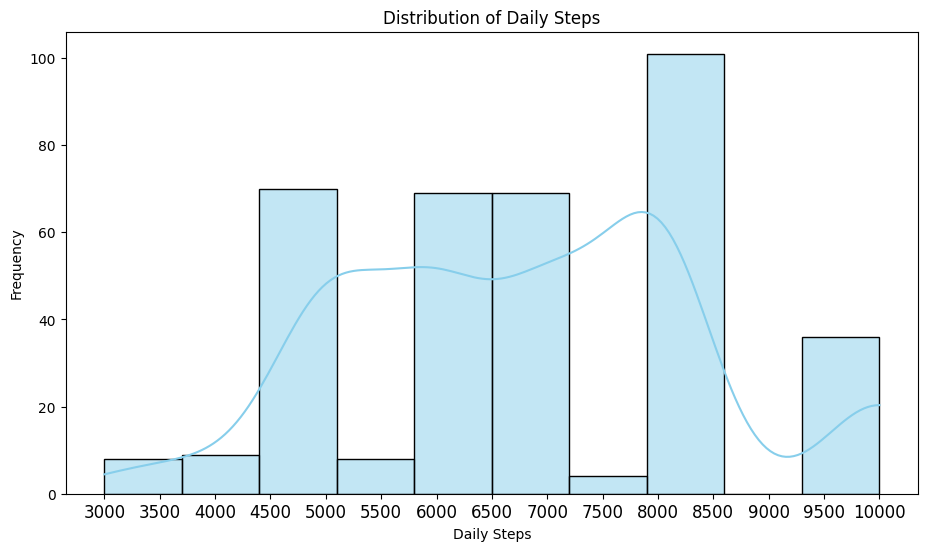

In [35]:
plt.figure(figsize=(11, 6))
sns.histplot(df["Daily Steps"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of Daily Steps")

plt.xlabel("Daily Steps")
plt.ylabel("Frequency")
plt.xticks(ticks=np.arange(df["Daily Steps"].min(), df["Daily Steps"].max()+2 , step=500), fontsize=12)

plt.show()

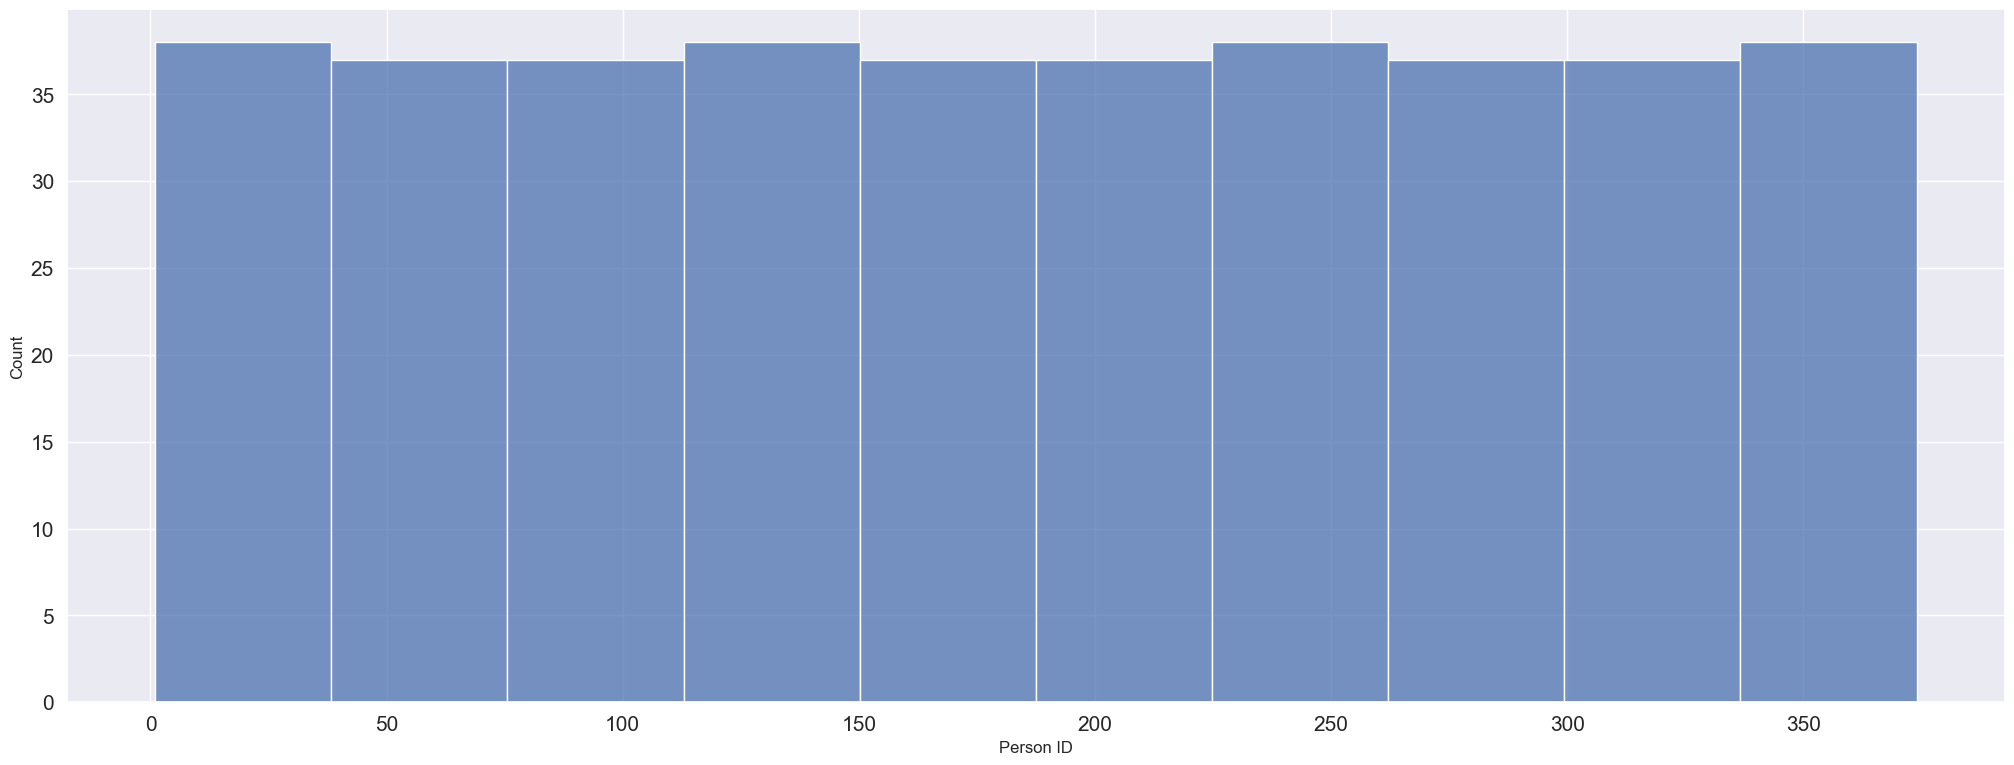

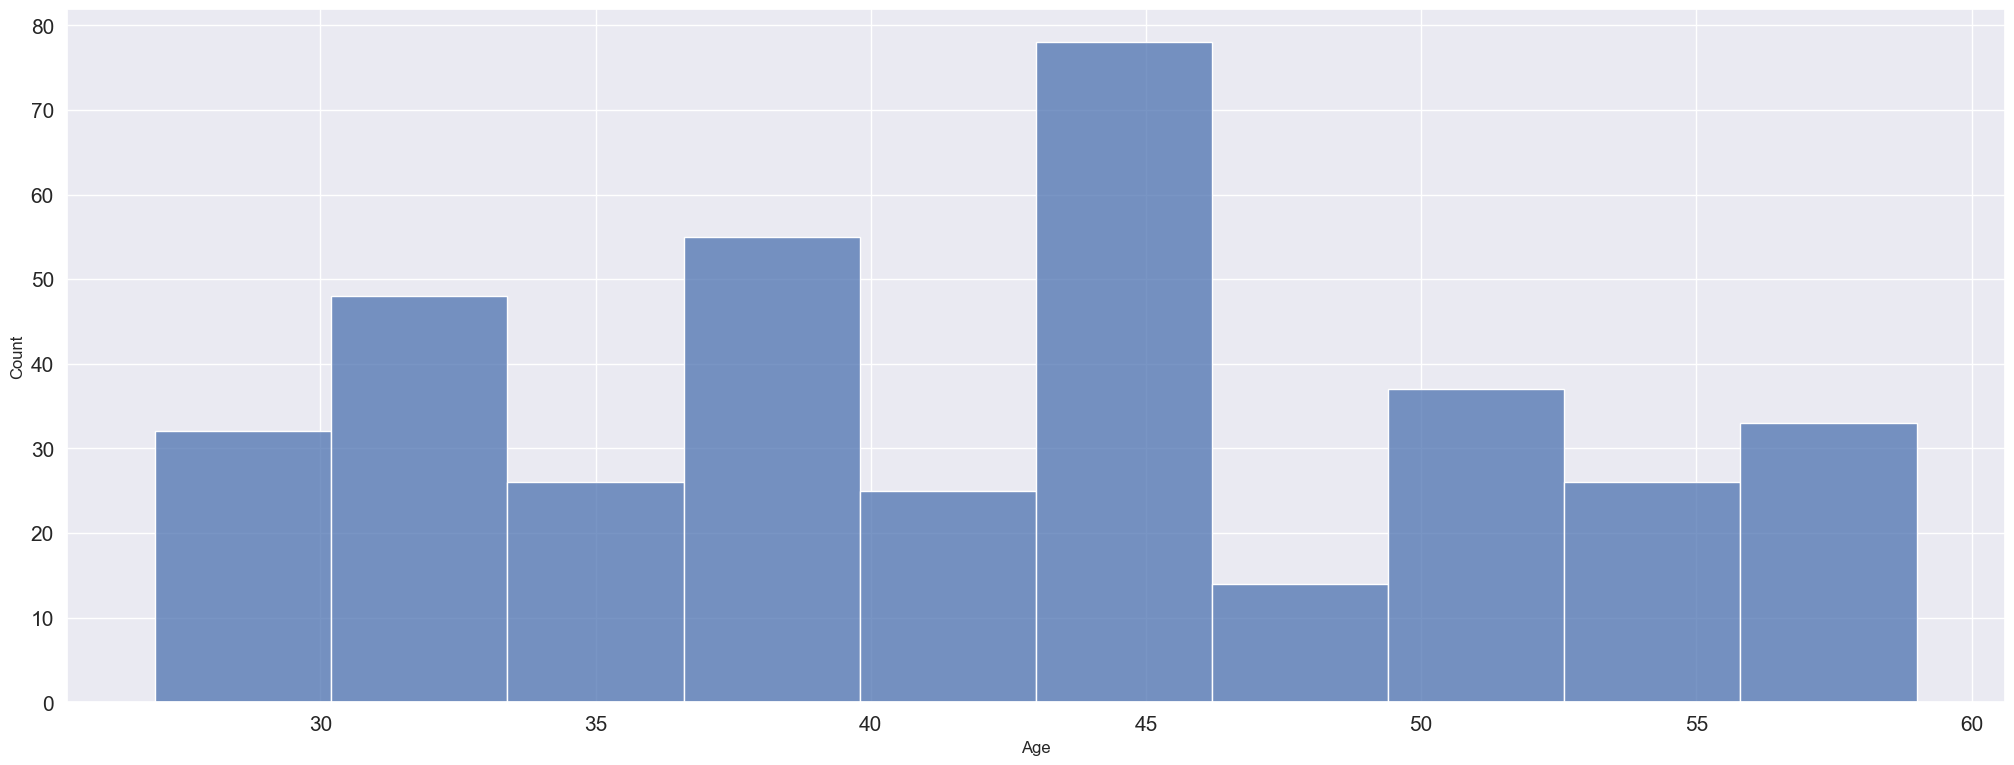

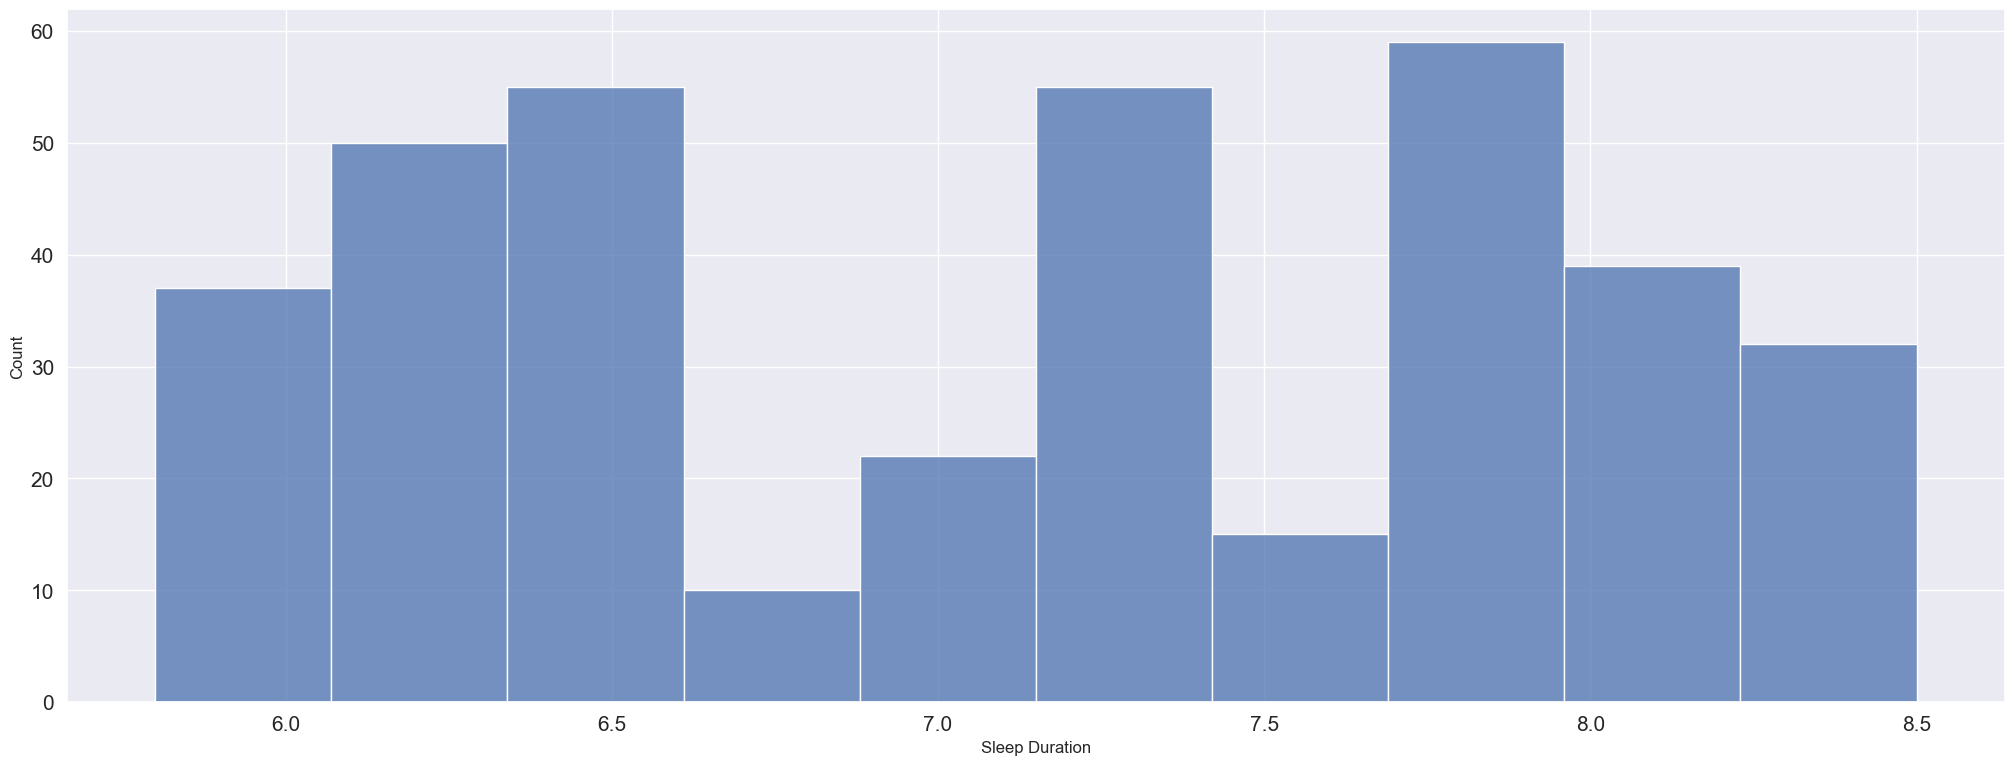

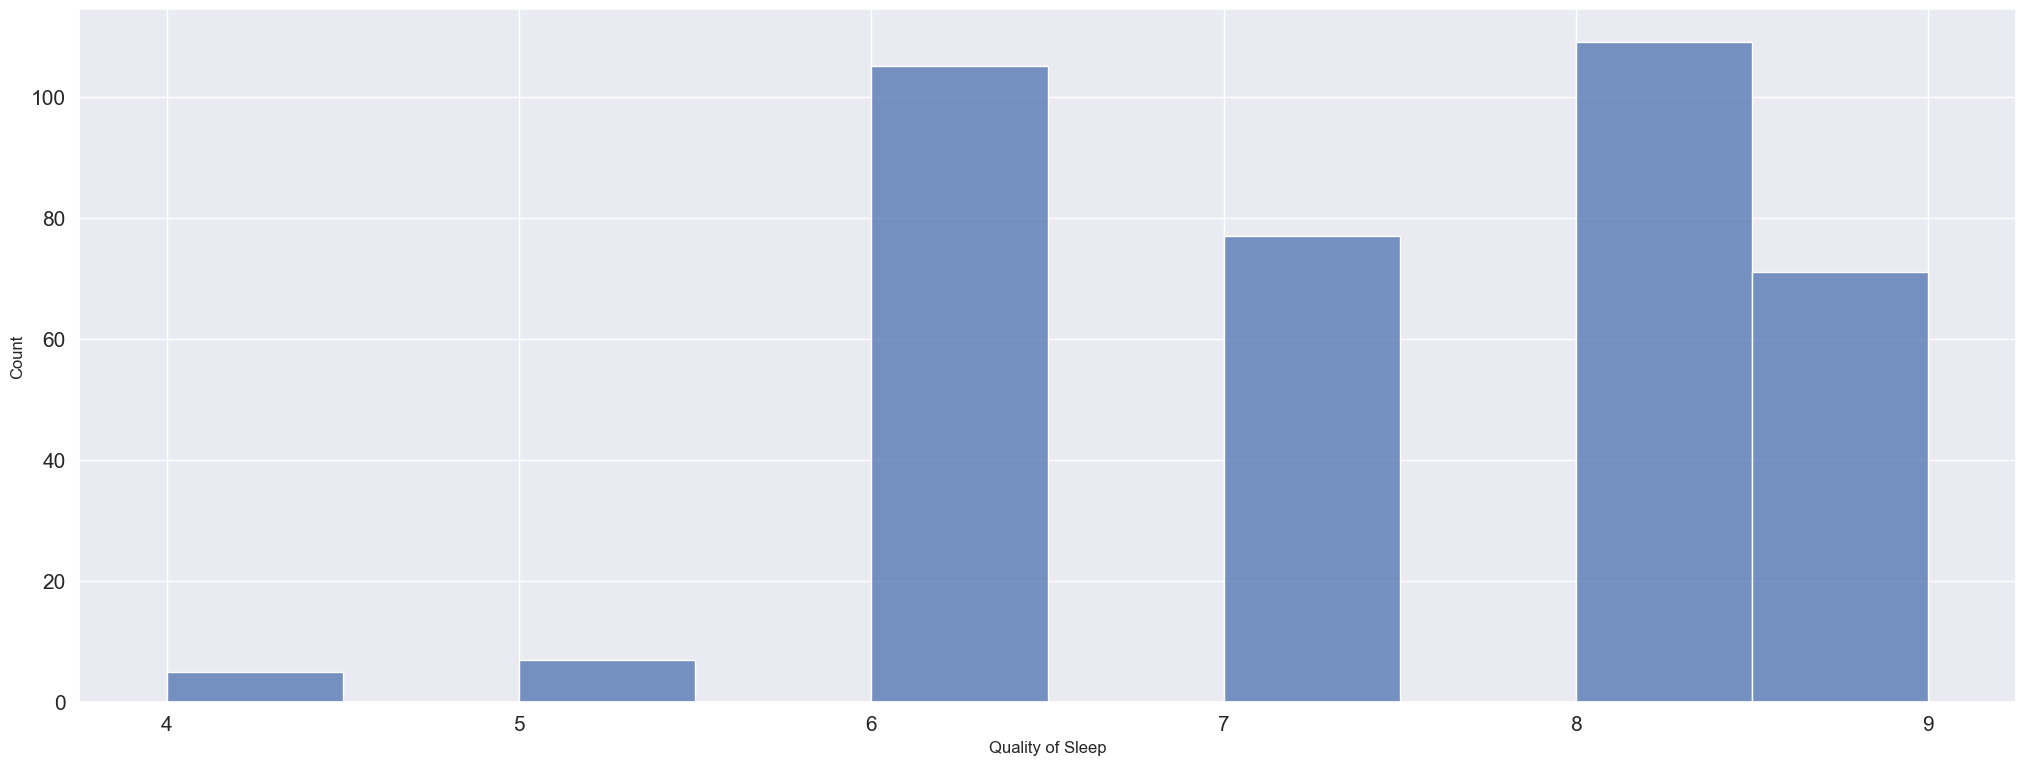

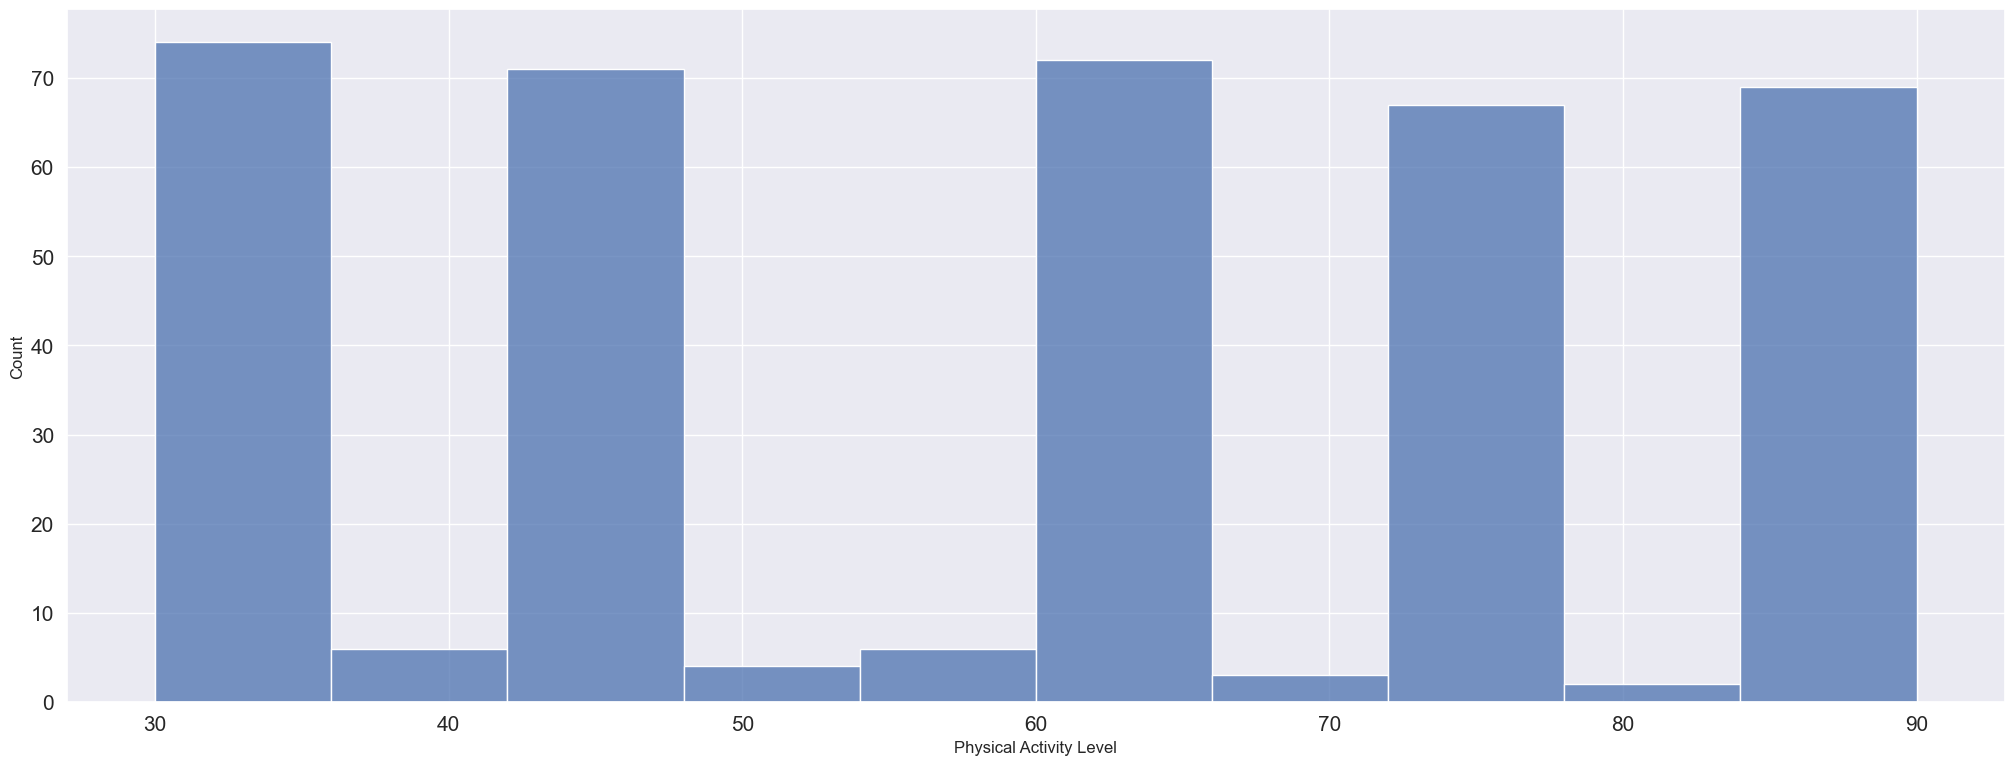

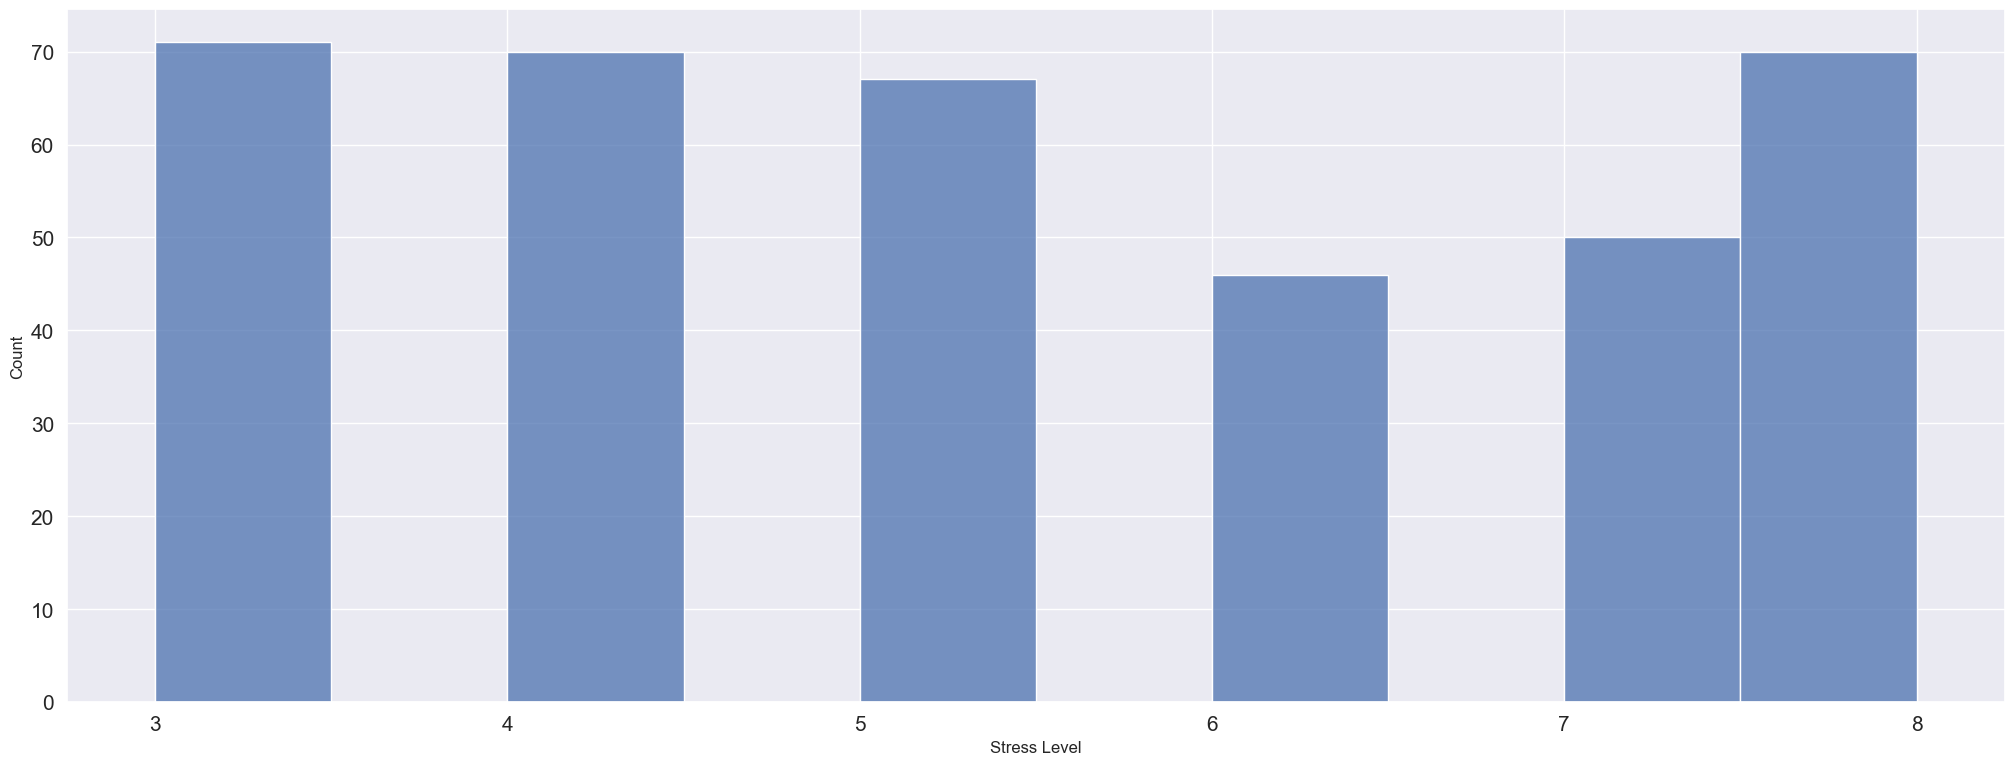

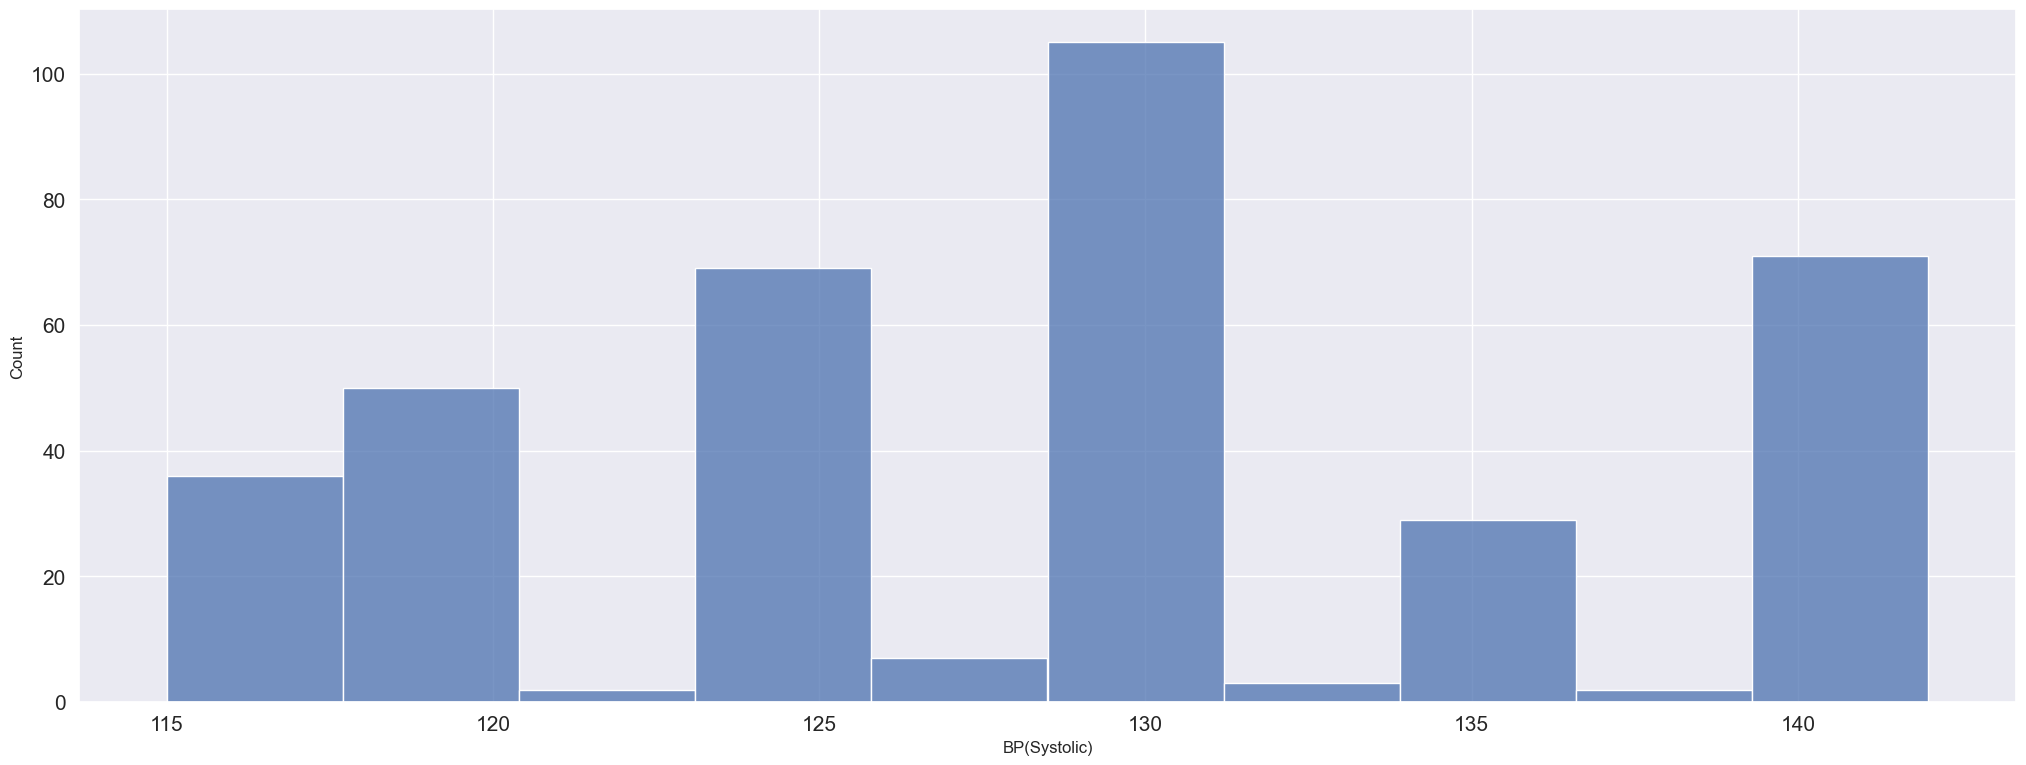

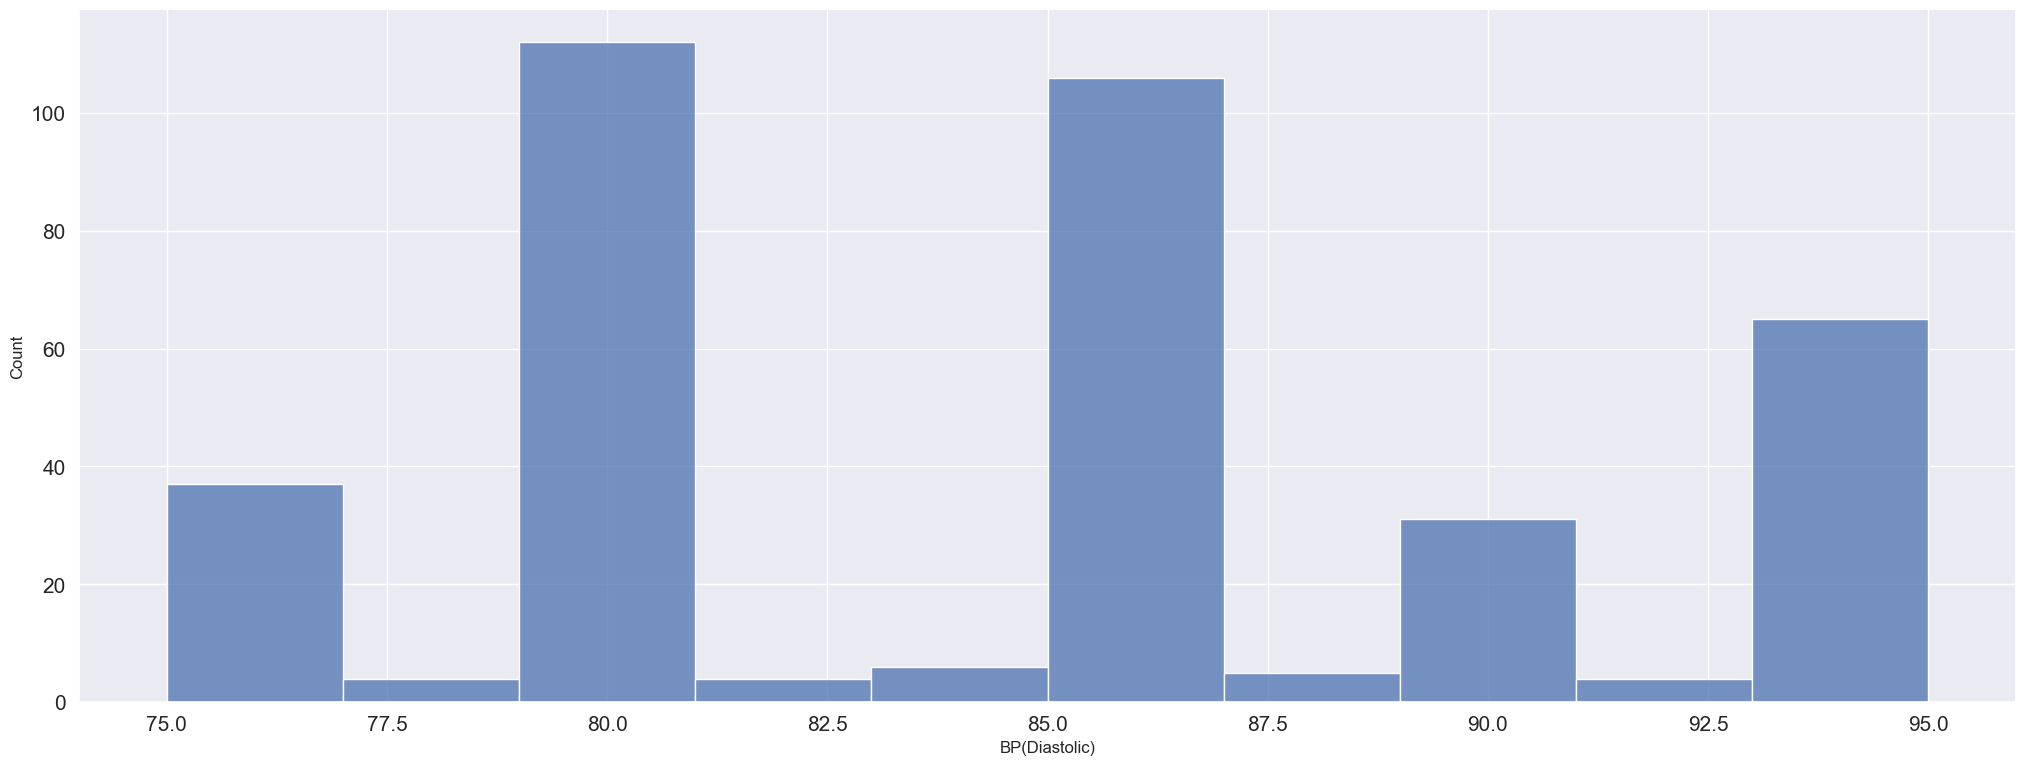

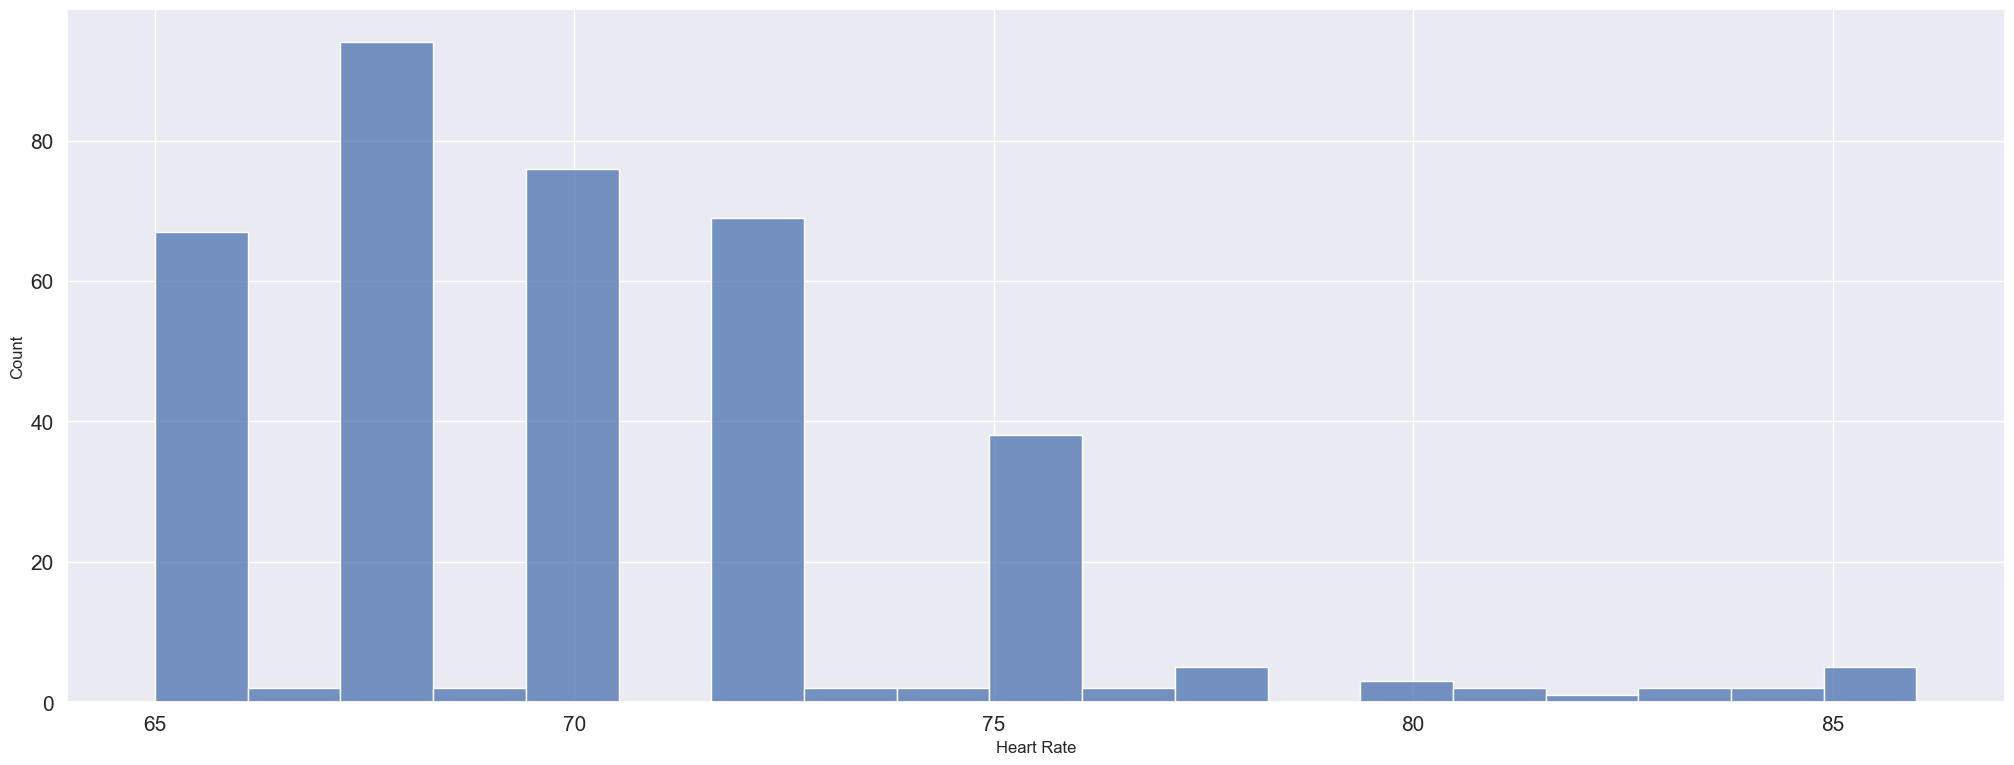

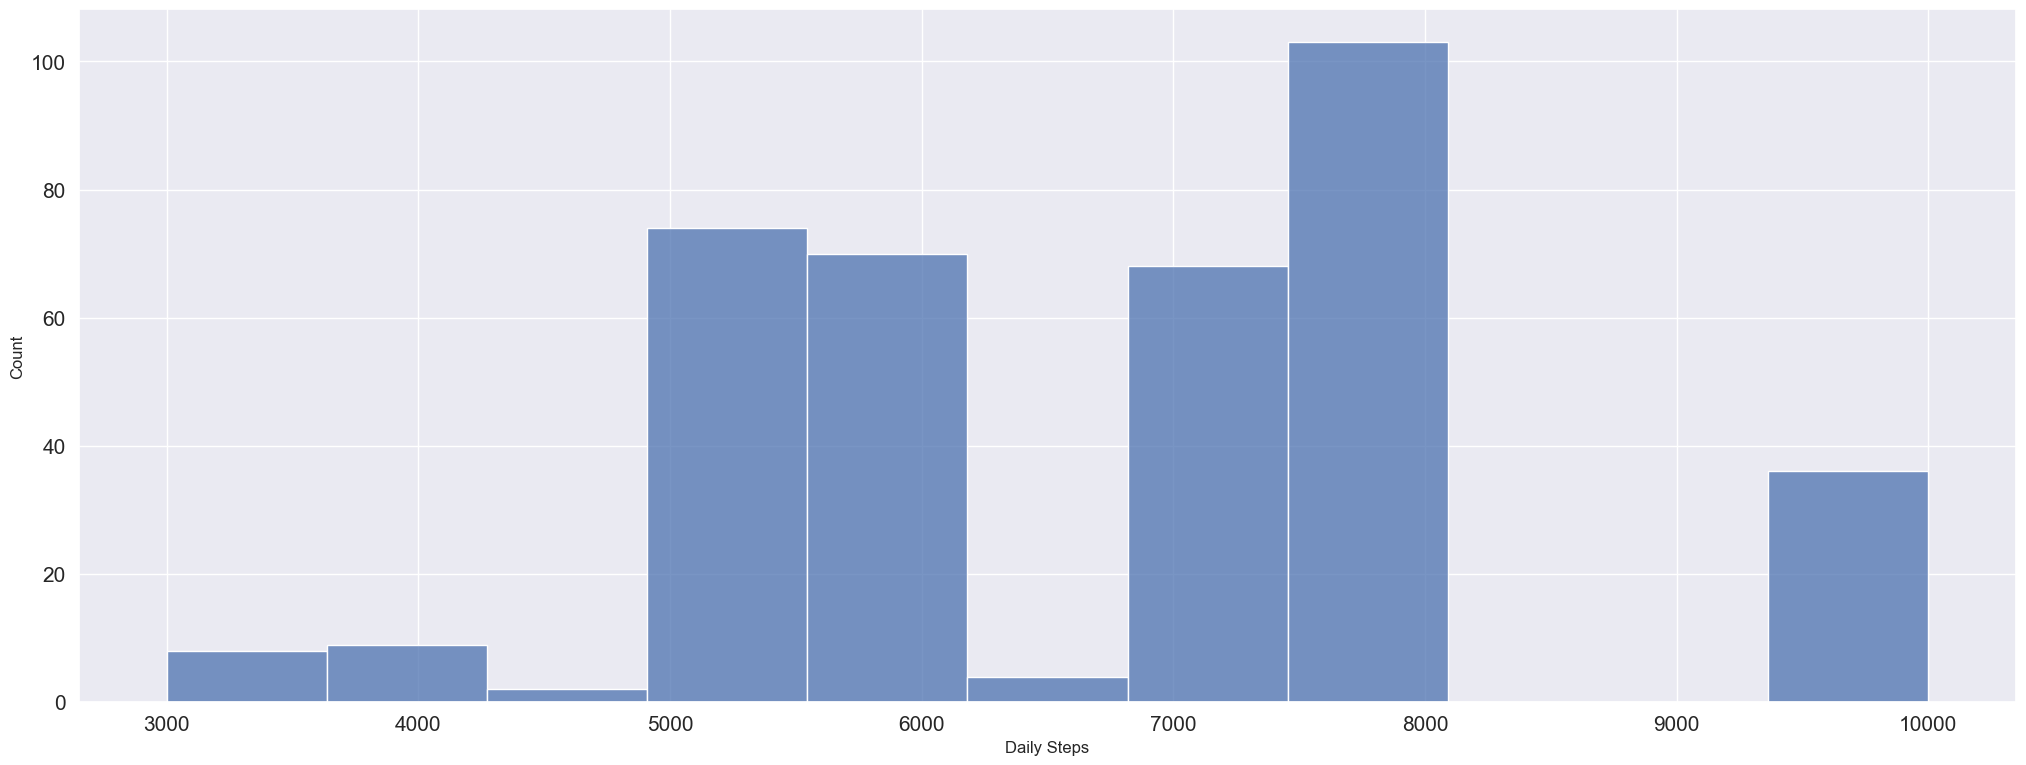

In [36]:
sns.set(rc = {'figure.figsize' : (25, 9)})
for i in df.select_dtypes(include = "number").columns:
    sns.histplot(data = df, x = i)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()

# Step-4: Prepare the data for Machine Learning algorithms.

## Preparing separate lists for categorical and numeric features(columns)

### For categorical features

In [37]:
categorical_features = []

for column in df.columns:
    if df[column].dtypes == "object":
        categorical_features.append(column)

categorical_features

['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

In [38]:
categorical_features.remove("Sleep Disorder")

In [39]:
categorical_features

['Gender', 'Occupation', 'BMI Category']

### For numerical features

In [40]:
numerical_features = []

for column in df.columns:
    if df[column].dtypes in ["int32", "int64", "float64"]:
        numerical_features.append(column)

numerical_features

['Person ID',
 'Age',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'BP(Systolic)',
 'BP(Diastolic)',
 'Heart Rate',
 'Daily Steps']

### These are the basic categories we use for final prediction(under the column Sleeping Disorder)

In [41]:
df["Sleep Disorder"].unique()

array(['None', 'Sleep Apnea', 'Insomnia'], dtype=object)

### These are the count of instances for people with sleeping disorders

In [42]:
df["Sleep Disorder"].value_counts()

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

## Data Cleaning

In [43]:
df.isna().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
BP(Systolic)               0
BP(Diastolic)              0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

### Since there are no null values in the dataframe, we can split them for model estimation

## Separate target and features

In [44]:
X = df.drop(columns=["Sleep Disorder"])
y = df["Sleep Disorder"]

## Splitting of Data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Handling text and categorical attributes

In [46]:
onehot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
label_encode = LabelEncoder()#for target column

#ColumnTransoformer
clmn_transformer = ColumnTransformer(
    transformers=[
        ('cat',onehot_encoder,categorical_features),
        ('num', scaler, numerical_features)
    ],
)

#fitting and transforming the  train data
X_train = clmn_transformer.fit_transform(X_train)
y_train = label_encode.fit_transform(y_train)
#transorming the test data
X_test = clmn_transformer.transform(X_test)
y_test = label_encode.transform(y_test)

#converting the results back tp dataframe
encoded_columns = clmn_transformer.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = list(encoded_columns) + numerical_features

# Check the shape of the transformed data
print("Shape of transformed data:", X_train.shape)
# Convert transformed data into a DataFrame
transformed_df = pd.DataFrame(X_train, columns=all_columns)

Shape of transformed data: (299, 27)


In [47]:
# View the transformed DataFrame and target column
transformed_df.columns

Index(['Gender_Female', 'Gender_Male', 'Occupation_Accountant',
       'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer',
       'Occupation_Manager', 'Occupation_Nurse',
       'Occupation_Sales Representative', 'Occupation_Salesperson',
       'Occupation_Scientist', 'Occupation_Software Engineer',
       'Occupation_Teacher', 'BMI Category_Normal',
       'BMI Category_Normal Weight', 'BMI Category_Obese',
       'BMI Category_Overweight', 'Person ID', 'Age', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BP(Systolic)', 'BP(Diastolic)', 'Heart Rate', 'Daily Steps'],
      dtype='object')

# Step-5: Select a model and train it

## Training and Evaluating on the Training set

In [48]:
# Normalize/standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(multi_class='ovr', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)

print("Logistic Regression:")
print(f"Accuracy: {accuracy_log_reg}")
print(f"Confusion Matrix:\n{conf_matrix_log_reg}")
print(f"Classification Report:\n{classification_rep_log_reg}")

# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_scaled, y_train)
y_pred_tree = tree_clf.predict(X_test_scaled)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
classification_rep_tree = classification_report(y_test, y_pred_tree)

print("\nDecision Tree Classifier:")
print(f"Accuracy: {accuracy_tree}")
print(f"Confusion Matrix:\n{conf_matrix_tree}")
print(f"Classification Report:\n{classification_rep_tree}")

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy_rf}")
print(f"Confusion Matrix:\n{conf_matrix_rf}")
print(f"Classification Report:\n{classification_rep_rf}")

svm_clf = SVC(random_state=42)  # By default, it uses the 'rbf' kernel
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

print("\nSupport Vector Machine:")
print(f"Accuracy: {accuracy_svm}")
print(f"Confusion Matrix:\n{conf_matrix_svm}")
print(f"Classification Report:\n{classification_rep_svm}")

Logistic Regression:
Accuracy: 0.88
Confusion Matrix:
[[14  1  1]
 [ 2 41  0]
 [ 3  2 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.93      0.95      0.94        43
           2       0.92      0.69      0.79        16

    accuracy                           0.88        75
   macro avg       0.86      0.84      0.84        75
weighted avg       0.89      0.88      0.88        75


Decision Tree Classifier:
Accuracy: 0.92
Confusion Matrix:
[[13  2  1]
 [ 0 43  0]
 [ 2  1 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.93      1.00      0.97        43
           2       0.93      0.81      0.87        16

    accuracy                           0.92        75
   macro avg       0.91      0.88      0.89        75
weighted avg       0.92      0.92      0.92        75


Ran

### These are the results of accuracy for various algorithms.

## Cross Validation

In [49]:
from sklearn.model_selection import cross_val_score

# Decision Tree Cross-validation
tree_model = DecisionTreeClassifier(random_state=42)

# Perform 5-fold cross-validation on the training set
tree_cv_scores = cross_val_score(tree_model, X_train_scaled, y_train, cv=10)

# Print cross-validation scores for each fold and the mean score
print("Decision Tree Cross-validation scores:", tree_cv_scores)
print("Decision Tree Mean cross-validation score:", tree_cv_scores.mean())

Decision Tree Cross-validation scores: [0.96666667 0.83333333 0.83333333 0.76666667 1.         0.86666667
 0.86666667 0.86666667 0.9        0.93103448]
Decision Tree Mean cross-validation score: 0.8831034482758622


In [50]:
rf_model = RandomForestClassifier()

# Perform 5-fold cross-validation on the training set
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10)

# Print cross-validation scores for each fold and the mean score
print("Random Forest Cross-validation scores:", rf_cv_scores)
print("Random Forest Mean cross-validation score:", rf_cv_scores.mean())

Random Forest Cross-validation scores: [0.96666667 0.86666667 0.86666667 0.83333333 1.         0.93333333
 0.93333333 0.86666667 0.9        0.93103448]
Random Forest Mean cross-validation score: 0.9097701149425289


### Since the cross validation score is highest for RandomForestClassifier comparatively, we pick it for fine tuning.

# Step-6: Fine-tune your model.

In [51]:
# Define the parameter grid for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': np.arange(2, 21, 1),
    'min_samples_leaf': np.arange(1, 21, 1),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}


# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Set up RandomizedSearchCV with 15-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, 
                                    param_distributions=param_dist_rf,
                                    n_iter=50,  # Number of random samples
                                    scoring='accuracy', cv=10,
                                    verbose=1, n_jobs=-1, random_state=42)

## Fitting the model to training data

In [52]:
random_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700]},
                   random_state=42, scoring='accuracy', verbose=1)

## Output the best parameters and accuracy

In [53]:
print("Best parameters for RandomForestClassifier:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

Best parameters for RandomForestClassifier: {'n_estimators': 400, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Best cross-validation accuracy: 0.913103448275862


## Evaluate the best model on the test set

In [54]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_split=14,
                       n_estimators=400)

# Step-6: Evaluate the Final Model

In [55]:
rf_pred = best_model.predict(X_test)

In [56]:
print('Accuracy: ', accuracy_score(y_test,rf_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test,rf_pred))
print('\nClassification report: \n',  classification_report(y_test,rf_pred))

Accuracy:  0.88

Confusion Matrix:
 [[13  1  2]
 [ 1 42  0]
 [ 4  1 11]]

Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.95      0.98      0.97        43
           2       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



In [69]:
# Save the model using pickle
with open('sleep_health_and_lifestyle.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [70]:
with open('column_transformer.pkl', 'wb') as transformer_file:
    pickle.dump(clmn_transformer, transformer_file)

In [71]:
# Load the LabelEncoder
with open('label_encoder.pkl', 'wb') as label_file:
    pickle.dump(label_encode, label_file)